## Power consumption prediction 

### Objective:

The aim of the project is to build a model to predict the power consumption, and to help achieve this objective there were two models used, the first being Regression modelling followed by a gradient boosting algorithm called XGBoost to arrive at our predictions.The performance of each of the models were then compared and their results interpreted to come at a conclusion.

### About our dataset:

Our project consists of energy consumption data obtained from openly available data from electric supplier, PJM Interconnection LLC.<br> The data is gathered from monitoring companies that are part of PJM Grid and consists of hourly energy consumption in Megawatts(MWs) from the year 2002 to 2018, covering the east region of the United States (Pennsylvania, Jersey and Maryland).

### Target Audience:

Our target audience mainly involves electricity suppliers looking to make their business process more efficient and eco-friendly. Predicting power consumption can be advantageous to the power generating and transmission companies in many ways. Some of the reasons are mentioned below:
-	Increase efficiency and revenues for the company – Knowing the consumption would help them plan their capacity and the required operations in order to meet the energy needs of the consumer.

-	Maximize utilization of power: Forecasting the demand helps give an idea of the energy needed. Hence avoiding under generation or over generation of power.

-	Informed maintenance activities: By knowing the demand, the company can know when to carry out maintenance activities such that the customers are least affected.

-	Minimize risks and help in smart investments: Understanding the future load would help the company to make economically feasible decisions about future electric generation and transmission investments.


### Obtain data:


In [3]:
import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression  # Linear regression
from sklearn import metrics
plt.style.use('fivethirtyeight')   


In [4]:
#Keeping the datetime as index value instead of a column, helps in dealing with time series data
df=pd.read_csv('PJME_hourly.csv',index_col=[0],parse_dates=[0])
df.sort_index(inplace=True)

df.head(10)

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
2002-01-01 06:00:00,28654.0
2002-01-01 07:00:00,29308.0
2002-01-01 08:00:00,29595.0
2002-01-01 09:00:00,29943.0


### Data Cleaning:

We will now check for any missing or null values in out data by the performing the below operations.

In [5]:
df.info() #Result shows no null values present

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
PJME_MW    145366 non-null float64
dtypes: float64(1)
memory usage: 2.2 MB


In [6]:
df.isna().sum() # No null vaules

PJME_MW    0
dtype: int64

As it can be seen above, our dataset is fairly consistent and doesn't contain missing or null values. Hence avoiding the need for imputation. We can now proceed with futher data analysis.

In [7]:
# To get an idea of any presence of outliers in our data
a=df[['PJME_MW']]
a.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


As seen above, we can  notice that the mean value is greater than the median value(index: 50 %), and in addition to that, there is a large difference between the values of the 75th%tile and the max value. Thus, from these two observations we can say that there are extreme values-outliers in our data set.

In [8]:
#Splitting orginal data into year for graphs below

df["Date"]=df.index
df["Year"] = df["Date"].dt.year
df = df[['PJME_MW','Year']]
df.head()

,PJME_MW,Year
Datetime,,
2002-01-01 01:00:00,30393.0,2002
2002-01-01 02:00:00,29265.0,2002
2002-01-01 03:00:00,28357.0,2002
2002-01-01 04:00:00,27899.0,2002
2002-01-01 05:00:00,28057.0,2002


### Data visualisation:

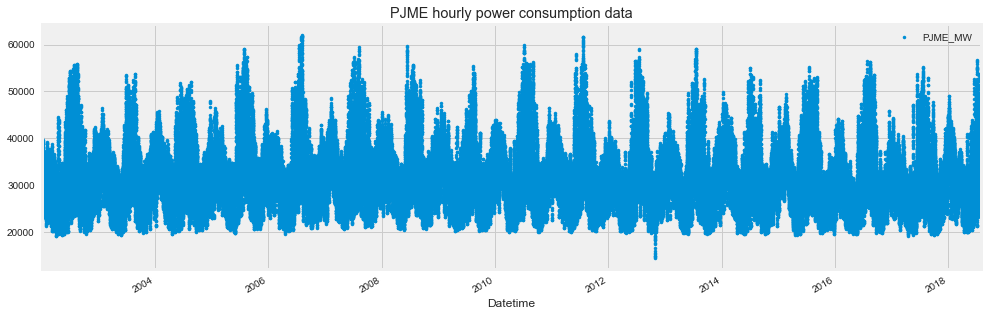

In [9]:
# To plot the energy consumption of the entire dataset
df.plot(figsize=(15,5),y='PJME_MW', style='.')
plt.title('PJME hourly power consumption data')
plt.show()

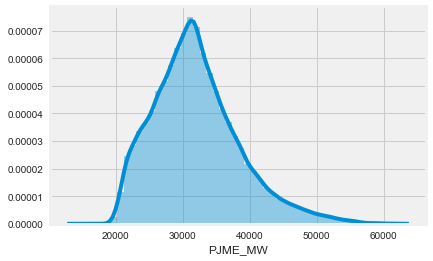

In [10]:
sns.distplot(df["PJME_MW"])

As seen above, the histogram helps find where the majority of data values fall in a measurement scale, in our example above,it can be seen that the most frequently occuring values from the hourly power consumption dataset is to be around ~30000 to 31000 kWatt .

### Splitting test and train data:


In [11]:
#Keeping the data of 1st January 2015 onwards as the test data
split_date = '2015-01-01 00:00:00'

model_train = df.loc[df.index <= split_date].copy()
model_test = df.loc[df.index >=split_date].copy()

In [12]:
model_train.head()

,PJME_MW,Year
Datetime,,
2002-01-01 01:00:00,30393.0,2002
2002-01-01 02:00:00,29265.0,2002
2002-01-01 03:00:00,28357.0,2002
2002-01-01 04:00:00,27899.0,2002
2002-01-01 05:00:00,28057.0,2002


In [13]:
model_test.head()

,PJME_MW,Year
Datetime,,
2015-01-01 00:00:00,32802.0,2015
2015-01-01 01:00:00,31647.0,2015
2015-01-01 02:00:00,30755.0,2015
2015-01-01 03:00:00,30189.0,2015
2015-01-01 04:00:00,29890.0,2015


In [14]:
#del model_train["Year"]
#del model_test["Year"]

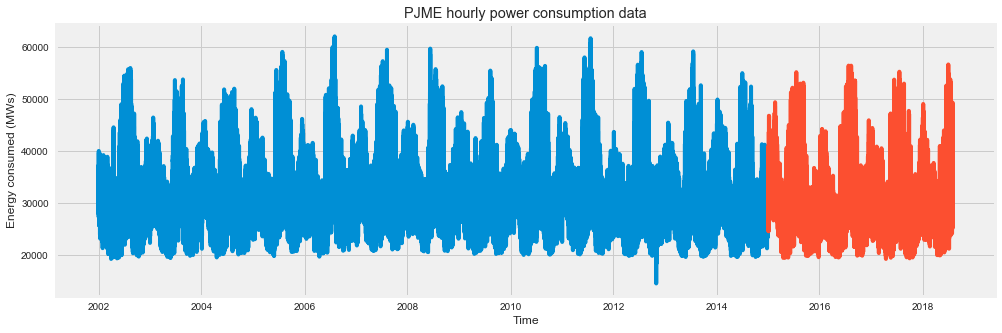

In [45]:
#Visualising the split
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Energy consumed (MWs)')
plt.title("PJME hourly power consumption data")
plt.plot(model_train.index,model_train["PJME_MW"])
plt.plot(model_test.index,model_test["PJME_MW"])
plt.show()
#plt.legend()


#plt.plot(xgb_train.index,xgb_train)

### Create time series features:

In [16]:
# Provide more datapoints that the model can find patterns from ranging from hour, month, week to year

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    #Keeping X as a dataframe and the y as a series
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [17]:
X_train, y_train = create_features(model_train, label='PJME_MW')
X_test, y_test = create_features(model_test, label='PJME_MW')

In [18]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-01-01 01:00:00,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,5,1,1,1,2002,1,1,1


In [19]:
y_train.head()

Datetime
2002-01-01 01:00:00    30393.0
2002-01-01 02:00:00    29265.0
2002-01-01 03:00:00    28357.0
2002-01-01 04:00:00    27899.0
2002-01-01 05:00:00    28057.0
Name: PJME_MW, dtype: float64

### Linear Regression

A simple linear regression model was used to find and visualize the relationship between the dependent and the independent variable. We performed linear regression on the data, keeping time as the independent variable and the energy consumed as the dependant variable.

In [20]:
linreg=LinearRegression()    # Instatiate variable

linreg.fit(X_train,y_train)  # Fit a model on training data 


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
print(linreg.intercept_)     # Gets the intercept value

print(linreg.coef_)          # Gets the coefficients of the features passed


115211.30609534576
[ 4.62222503e+02 -6.16293587e+02 -2.50772812e+02 -9.42295221e+03
 -3.79263204e+01  3.09715950e+02 -3.07596977e+02 -5.04427440e-01]


In [22]:
lin_pred=linreg.predict(X_test)  # Makes predictions of the test data

print(lin_pred)                 # Get the predictions


[27268.77922399 27731.00172749 28193.22423099 ... 36508.45170182
 36970.67420532 25725.38201042]


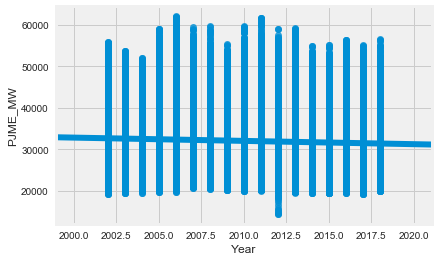

In [23]:
# Visualising the linear regression relationship
sns.regplot(x='Year',y='PJME_MW',data=df)

#### Evaluating the model

In [24]:
# Have used three primary metrics for evaluating the model
print("MAE: ",metrics.mean_absolute_error(y_test,lin_pred))

print("MSE: ",metrics.mean_squared_error(y_test,lin_pred))

print("RMSE: ",np.sqrt(metrics.mean_squared_error(y_test,lin_pred)))

MAE:  4588.852703337567
MSE:  32171245.915417153
RMSE:  5671.970196978926


From the above, it can be seen that the linear regression model provides an aggregate error of around 4000 to 5000 MWs from the actual data. Also, it doesn't help to predict the consumption values when it comes to a day-to-day or a monthly basis. It just gives us information of an overall decreasing trend of energy with respect to time.

### The XGB Regressor model:

XGBoost or Extreme Gradient Boosting is an example of a boosting algorithm, which is an ensemble technique in which the predictors are not made independently, but sequentially.

This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors. Because new predictors are learning from mistakes committed by previous predictors, it takes less time or iterations to reach close to the actual predictions. But we have to choose the stopping criteria carefully or it could lead to overfitting on training data. 


### Why XGBoost?

The XGBoost model uses ensembles which involves different predictors trying to predict the same target variable which will perform a better job than using a single predictor alone. Using ensembles helps to reduce these factors (except noise, which is irreducible error). <br>
<br>The advantage of this iterative approach is that the new models being added are focused on correcting the mistakes which were caused by other models.
 In a standard ensemble method where models are trained in isolation, all of the models might simply end up making the same mistakes!
 




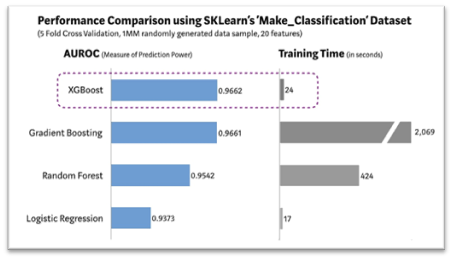

When comparing the performance of multiple algorithms given a set of data points and corresponding features, it was found out that the XGBoost model has the best combination of prediction performance and processing time as compared to other algorithms.

In [25]:
# Creating a XGB model

reg = xgb.XGBRegressor(n_estimators=1000)   # Have used 1000 estimators as the size of our data is medium-low
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,           # Stop if 50 consequent rounds without decrease of error
        verbose=False)

C:\Users\astro\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\astro\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[18:22:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

#### Feature Importance

Feature importance helps in getting an understanding of which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

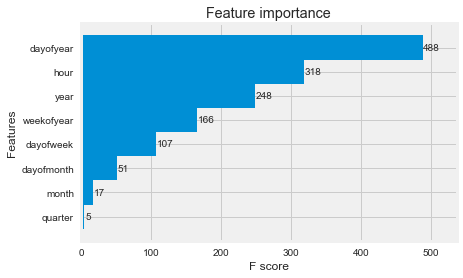

In [26]:
xgb.plot_importance(reg, height=1)

As we can see above,the 'dayofyear' feature was most commonly used to split trees, while 'hour' and 'year' came in next. 'quarter' has low importance due to the fact that it could be created by different 'dayofyear' splits.

#### Forecast on the test set

In [27]:
#Function to plot the graphs for given data or time interval
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    
    plt.plot(df.index,df['PJME_MW'], label='Actual data')
    plt.plot(X_test.index,X_test_pred, label='Predicted data')
    plt.xlabel('Time')
    plt.ylabel('Energy units consumed (MWs)')
    plt.legend()
   
    plt.xlim(left=date_from, right=date_to)

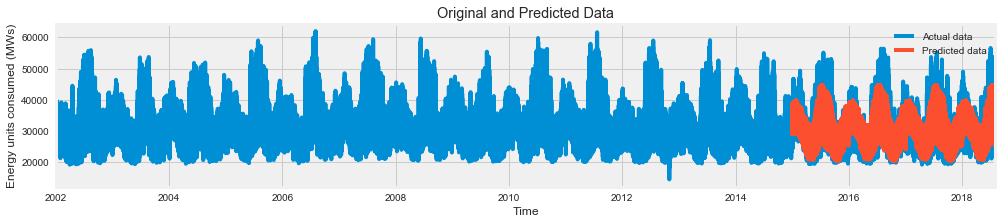

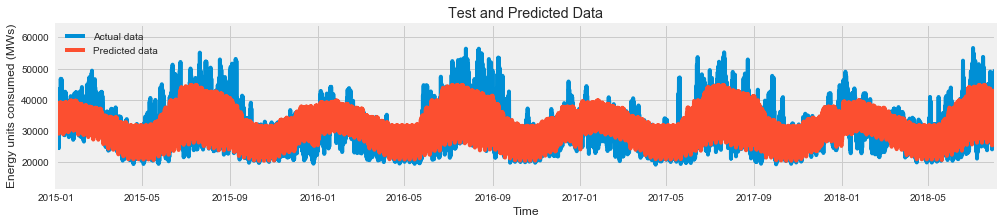

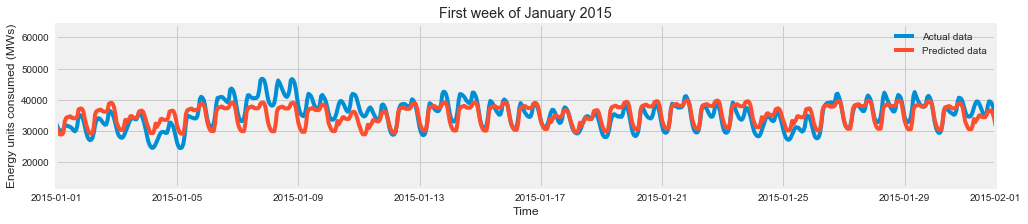

In [28]:
X_test_pred = reg.predict(X_test)
    
plot_performance(df, df.index[0].date(), df.index[-1].date(),
                 'Original and Predicted Data')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')

plot_performance(y_test, '01-01-2015', '02-01-2015','First week of January 2015') # Plot the first forecasted month

plt.legend()

plt.show()



#### Forecast for five random weeks:

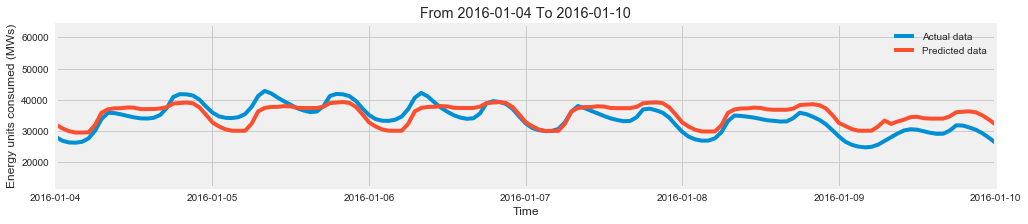

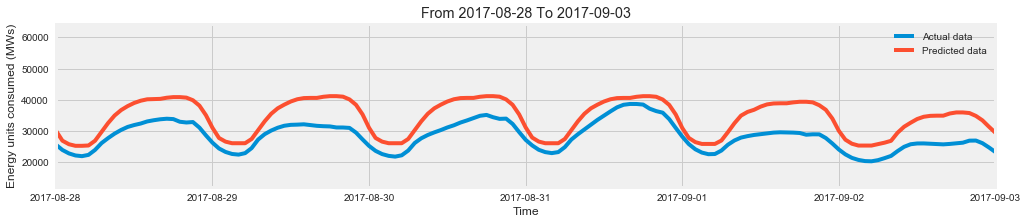

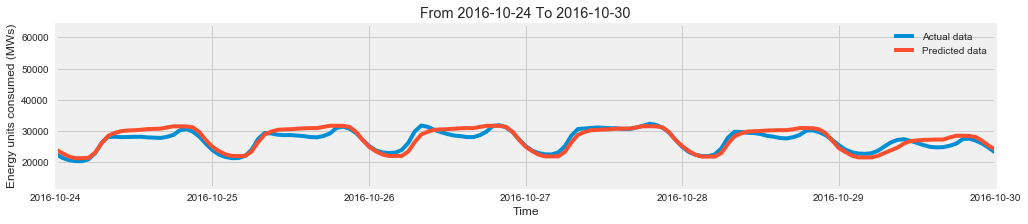

In [29]:
random_weeks = X_test[['year', 'weekofyear']].sample(3)
for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & \
            (X_test.weekofyear == week[1].weekofyear)
    data = y_test[index]
    plot_performance(data, data.index[0].date(), data.index[-1].date())

#### Evaluating the performance of the model: 

In [30]:
#MAE
mean_absolute_error(y_true=y_test,
                    y_pred=X_test_pred)

2848.8349176382594

In [31]:
#Function to calculate the MAPE values from the actual and predicted values
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [32]:
#MAPE
mean_absolute_percentage_error(y_test,X_test_pred)

8.94926604873917

In [33]:
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

13780043.810609682

From the above metrics, we see that using the XGB model produces an average error of around 3000 units from the actual values(MAE) and a deviation of 8.9 % (MAPE) from the actuals. This is a definite improvement from using the linear regression model to make predictions.

#### Comparing the accuracy of the forecasts:

In [34]:
#Constructing the comparison table 

X_test['PJME_MW'] = y_test
X_test['MW_Prediction'] = X_test_pred
X_test['error'] = y_test - X_test_pred   # MAE1
X_test['abs_error'] = X_test['error'].apply(np.abs)
error_by_day = X_test.groupby(['year','month','dayofmonth']) \
   .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

# List the values with the worst prediction
error_by_day.sort_values('error', ascending=True).head(10)


C:\Users\astro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\astro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36986.964844 -8587.006429  8587.006429
2017 2     24          26445.083333   33814.503906 -7369.422445  7369.422445
2015 12    25          24466.083333   31584.923828 -7118.841390  7118.841390
2017 2     20          27070.583333   34100.781250 -7030.197754  7030.197754
2015 7     3           30024.875000   37021.031250 -6996.156169  6996.156169
2017 6     28          30531.208333   37526.589844 -6995.380371  6995.380371
     2     8           28523.833333   35511.699219 -6987.864258  6987.864258
     9     2           24201.458333   31180.390625 -6978.933105  6978.933105
     2     25          24344.458333   31284.279297 -6939.820150  6939.820150
2018 2     21          27572.500000   34477.417969 -6904.919352  6904.919352

In [35]:
# List the values with the best prediction
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    3           27705.583333   27775.351562  -69.768148  229.585205
2015 10    28          28500.958333   28160.875000  340.083740  388.023356
2016 10    8           25183.333333   25535.669922 -352.337402  401.017090
     5     1           24503.625000   24795.419922 -291.794515  428.289307
2017 10    29          24605.666667   24776.271484 -170.605225  474.628988
2016 9     16          29258.500000   29397.271484 -138.770833  491.070312
     3     20          27989.416667   27620.132812  369.284831  499.750488
     10    2           24659.083333   25134.919922 -475.836670  516.188232
2017 10    14          24949.583333   25399.728516 -450.145996  520.855794
2015 5     6           28948.666667   28710.271484  238.396077  546.640544

#### Plotting the worst and the best predictions

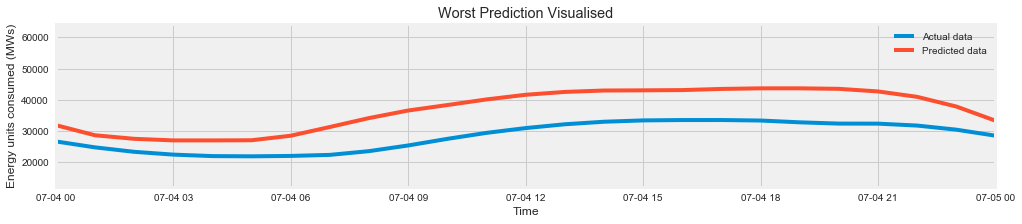

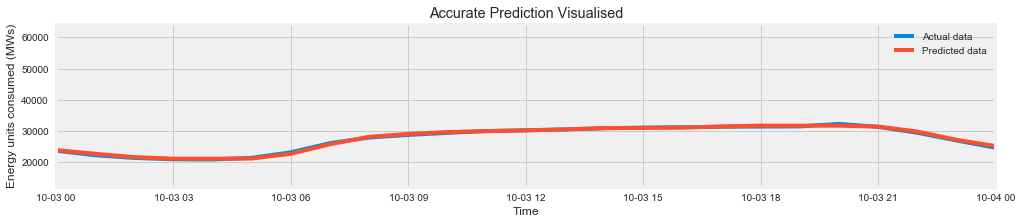

In [47]:
plot_performance(y_test, '07-04-2016', '07-05-2016','Worst Prediction Visualised') # 4th July 2016

plot_performance(y_test, '10-03-2016', '10-04-2016','Accurate Prediction Visualised') #3rd October 2016

As it can be seen above, there are some patterns that justify the predictions made by the model:<br>

    - The worst predicted day is 4th of July, which is also celebrated as the Independence day in the United States. Also, the third worst prediction is of 25th December, which is Christmas.From this, one could say that the consumption of energy increases during holidays.
    
    - The best predictions came consistently in the month of October, where the weather is mild the whole month. 

To conclude, the model could be made better by using the following:

-	The model could be improved if the holidays would be considered beforehand, implementing some sort of a holiday indicator could help in better prediction. 
-	Now that we know that there is a weather factor in getting an accurate prediction, incorporating the weather data of the region could help the model in making more accurate and better predictions.
-	In addition to that, tuning the parameters (various parameters like tree-specific, boosting and other parameters) can help in improving the overall performance of the model.


### References:

Linear Regression:
-  https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

XGBOOST:
-  https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d
XGBOOST parameter tuning:
-	https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
-	https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Error Metrics:
-	https://www.dataquest.io/blog/understanding-regression-error-metrics/

Linear Modeling Regression
-	https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606
